In [25]:
import time
import cv2
import numpy as np
import sys
import getopt
import operator
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from skimage import feature
from scipy import ndimage

from pylab import *
from scipy import signal
import scipy as scipy
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D


In [26]:
def read_image(IMG_NAME):
    img = mpimg.imread(IMG_NAME)
    return img

In [27]:
#function for part 1
def fit_fundamental(matches):
    """returns fundamental matrix by solving linear system of match points"""
    
    #calculating A
    N = matches.shape[0]
    A = np.ones((N,9))
    for i in np.arange(N):
         
        x1, y1, x2, y2 = matches[i]
        A[i,0] = x1*x2
        A[i,1] = y1*x2
        A[i,2] = x2
        A[i,3] = x1*y2
        A[i,4] = y1*y2
        A[i,5] = y2
        A[i,6] = x1
        A[i,7] = y1
    
    #solving eigenvalue problem to find initial F
    u, s, vh = np.linalg.svd(A)
    F = vh[-1].reshape(3,3)
    
    #finding F
    u, s, vh = np.linalg.svd(F)
    s[-1] = 0
    s = s*np.eye(3)
    F = np.matmul(np.matmul(u,s),vh)

    return F

Residual = 2.237977425349455


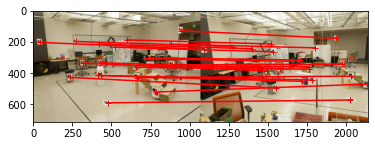

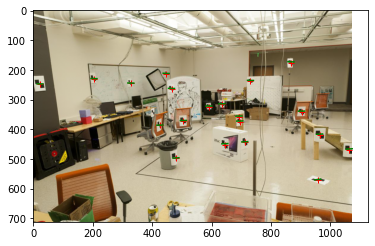

In [28]:
# Part 1: the code runs with help from function defind above

    
##
## load images and match files for the first example
##

I1 = Image.open('lab1.jpg');
I2 = Image.open('lab2.jpg');
matches = np.loadtxt('lab_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype(float)/255)
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
fig.savefig('2-1.svg',format='svg')

##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype(float)/255)
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
fig.savefig('2-2.svg',format='svg')

#finding residual
Residual = np.mean(np.abs(pt_line_dist))
print('Residual =', Residual)

In [10]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [24]:
#part 2
points_3d = np.loadtxt('lab_3d.txt')
points_2d = np.loadtxt('lab_matches.txt')

N = len(points_2d)
points_3d = np.concatenate((points_3d,np.ones((N,1))),axis = 1)

#calculating M according to points from the first picture
M = np.zeros((2*points_2d.shape[0],12))
for i in np.arange(points_2d.shape[0]):
    
    Xi = points_3d[i]
    
    M[2*i,0:4] = Xi
    M[2*i,8:12] = -Xi*points_2d[i,0]
    
    M[2*i+1,4:8] = Xi
    M[2*i+1,8:12] = -Xi*points_2d[i,1]
    
#solving eigenvalue pronlem to find projection matrix from first image
u, s, vh = np.linalg.svd(M)
PI1 = vh[-1].reshape(3,4)  
print('Camera Projection Matrix 1 =', PI1)
    
# finding point projections and residual from first image
points_3d_proj, residual = evaluate_points(PI1, points_2d[:,0:2], points_3d[:,0:3])
print('Residual1 =', residual)

#repeating the process for the second image
M = np.zeros((2*points_2d.shape[0],12))
for i in np.arange(points_2d.shape[0]):
    
    Xi = points_3d[i]
    
    M[2*i,0:4] = Xi
    M[2*i,8:12] = -Xi*points_2d[i,2]
    
    M[2*i+1,4:8] = Xi
    M[2*i+1,8:12] = -Xi*points_2d[i,3]
    
u, s, vh = np.linalg.svd(M)
PI2 = vh[-1].reshape(3,4) 
print('Camera Projection Matrix 2 =', PI2)

points_3d_proj, residual = evaluate_points(PI2, points_2d[:,2:4], points_3d[:,0:3])
print('Residual2 =', residual)

Camera Projection Matrix 1 = [[ 3.09963996e-03  1.46204548e-04 -4.48497465e-04 -9.78930678e-01]
 [ 3.07018252e-04  6.37193664e-04 -2.77356178e-03 -2.04144405e-01]
 [ 1.67933533e-06  2.74767684e-06 -6.83964827e-07 -1.32882928e-03]]
Residual1 = 13.545832902721848
Camera Projection Matrix 2 = [[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
Residual2 = 15.544953451380152


In [21]:
#part 3
u, s, vh = np.linalg.svd(PI1)
center1 = vh[-1]/vh[-1,-1]
u, s, vh = np.linalg.svd(PI2)
center2 = vh[-1]/vh[-1,-1]

print('Center 1 =', center1)
print('Center 2 =', center2)

Center 1 = [305.83276769 304.20103826  30.13699243   1.        ]
Center 2 = [303.10003925 307.18428016  30.42166874   1.        ]


In [13]:
def triangulate(PI1, PI2, matches):
    """returns linear triangulation of points in a 3D space
    also returns residual of 3D points projected back onto 2D space"""
    
    N = matches.shape[0]
    p1 = np.concatenate((matches[:,0:2], np.ones((N,1))), axis=1)
    p2 = np.concatenate((matches[:,2:4], np.ones((N,1))), axis=1)
    
    X = np.zeros((N,4))
    for i in range(N):
        xi1 = np.array([[0,-p1[i,2],p1[i,1]],[p1[i,2],0,-p1[i,0]],[-p1[i,1],p1[i,0],0]])
        xi2 = np.array([[0,-p2[i,2],p2[i,1]],[p2[i,2],0,-p2[i,0]],[-p2[i,1],p2[i,0],0]])  
        
        A1 = np.matmul(xi1,PI1)
        A2 = np.matmul(xi2,PI2)
        A = np.concatenate((A1,A2),axis=0)

        u, s, vh = np.linalg.svd(A)
        X[i] = vh[-1] / vh[-1,-1]
    
    residual = 0
    for i in range(N):
        x1 = np.matmul(PI1,X[i])
        x1 /= x1[-1]
        x2 = np.matmul(PI2,X[i])
        x2 /= x2[-1]
        residual += np.linalg.norm(x1-np.concatenate((matches[i,0:2], np.ones((1))))) 
        residual += np.linalg.norm(x2-np.concatenate((matches[i,2:4], np.ones((1))))) 
    residual /= (2*N)
    
    return X, residual

Residual = 0.7060383435134991


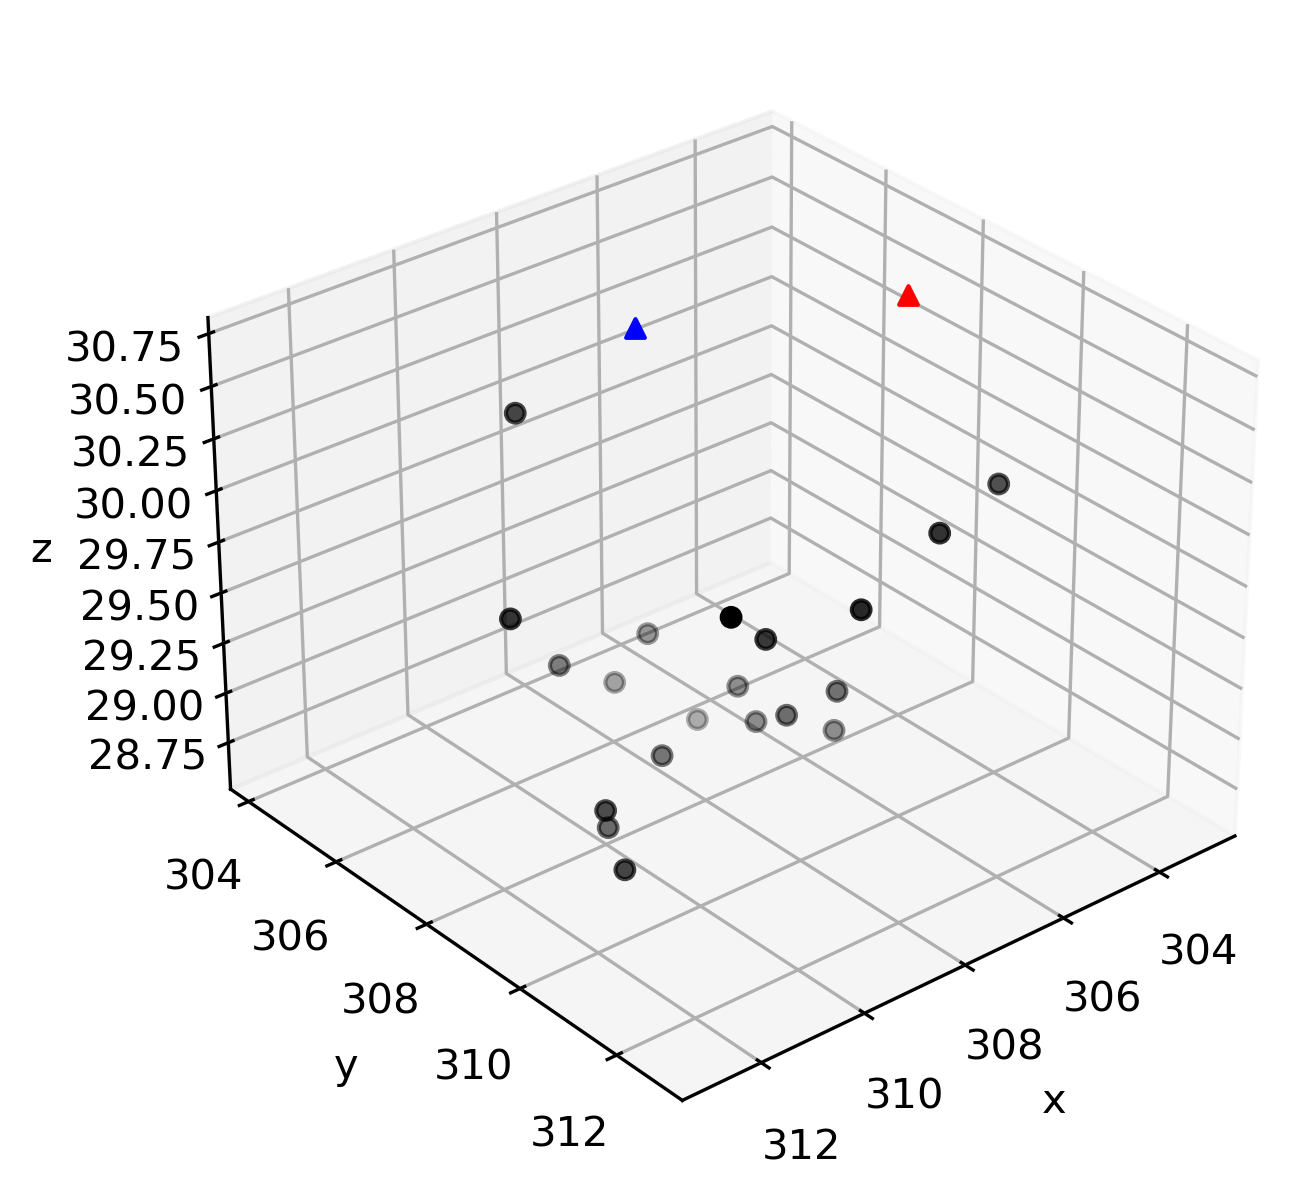

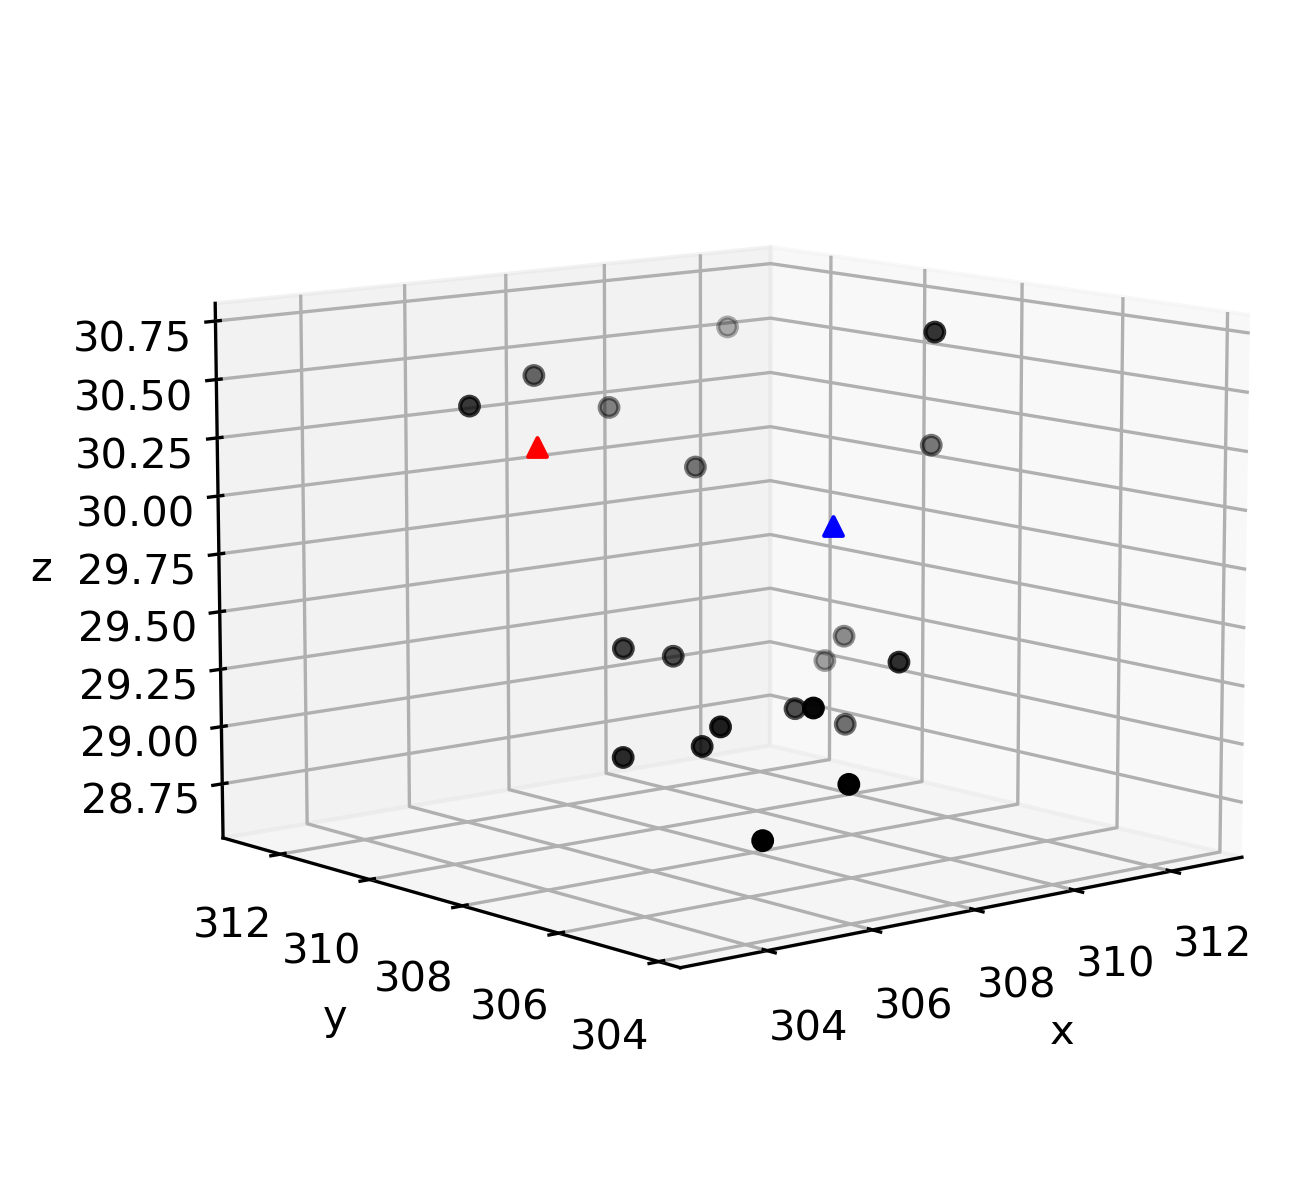

In [23]:
# part 4
X, residual = triangulate(PI1, PI2, points_2d)
print('Residual =', residual)

fig = plt.figure(figsize=[5,5],dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 50)
ax.scatter(X[:,0], X[:,1], X[:,2],color = 'black')
ax.scatter(center1[0],center1[1],center1[2],color = 'blue', marker = '^')
ax.scatter(center2[0],center2[1],center2[2],color = 'red', marker = '^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# fig.savefig('2-3d1.svg',format='svg')

fig = plt.figure(figsize=[5,5],dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, -130)
ax.scatter(X[:,0], X[:,1], X[:,2],color = 'black')
ax.scatter(center1[0],center1[1],center1[2],color = 'blue', marker = '^')
ax.scatter(center2[0],center2[1],center2[2],color = 'red', marker = '^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# fig.savefig('2-3d2.svg',format='svg')

In [29]:
print(F)

[[-5.36264198e-07  7.90364771e-06 -1.88600204e-03]
 [ 8.83539184e-06  1.21321685e-06  1.72332901e-02]
 [-9.07382264e-04 -2.64234650e-02  9.99500092e-01]]
